# Income Prediction Model - Complete Analysis

This notebook demonstrates our **custom Logistic Regression implementation** with mathematical transparency.

**Key Features:**
- Custom gradient descent implementation
- Clear mathematical operations (sigmoid, log loss, gradients)
- Pre-split train/validation data for reproducibility

In [135]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from utils import load_model

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


## 1. Load Pre-Split Data and Model

We use pre-split data to ensure reproducibility and fair evaluation.

In [136]:
# Load the pre-split data
train_df = pd.read_csv('../data/train_split.csv')
val_df = pd.read_csv('../data/val_split.csv')

X_train = train_df.drop(columns=["income_>50K"])
y_train = train_df["income_>50K"]

X_val = val_df.drop(columns=["income_>50K"])
y_val = val_df["income_>50K"]

# Load trained model
model = load_model()

# Make predictions
preprocessor = model.named_steps['preprocess']
logreg = model.named_steps['logreg']

X_val_processed = preprocessor.transform(X_val)
y_pred = logreg.predict(X_val_processed)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print("✓ Data and model loaded successfully!")

Training samples: 35165
Validation samples: 8792
✓ Data and model loaded successfully!


## 2. Custom Logistic Regression - Training Curve

Our implementation uses gradient descent. Let's visualize the learning process.

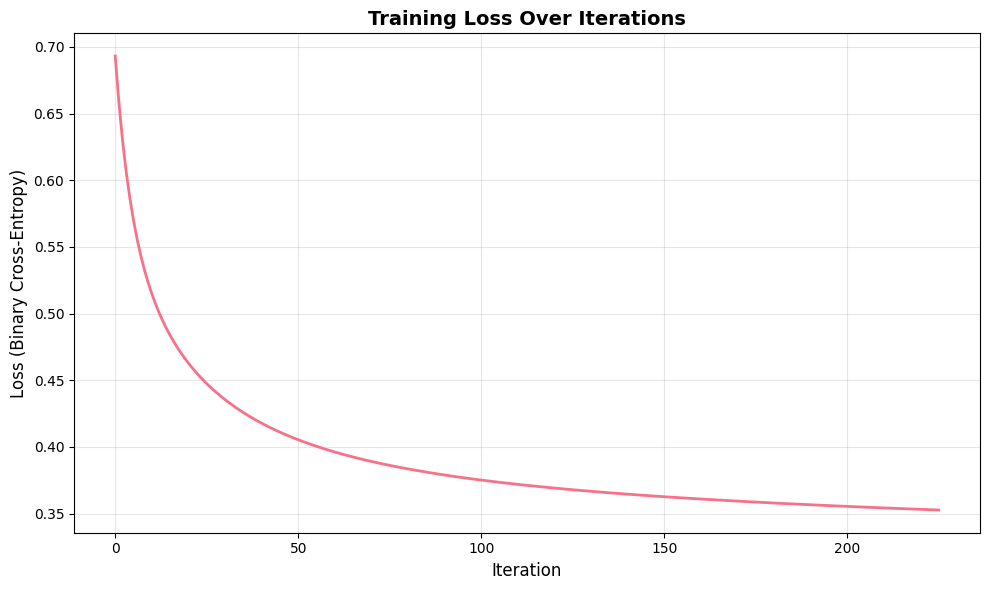

Final loss: 0.3527
Total iterations: 226


In [137]:
# Plot training loss curve
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(logreg.losses, linewidth=2)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Loss (Binary Cross-Entropy)', fontsize=12)
ax.set_title('Training Loss Over Iterations', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final loss: {logreg.losses[-1]:.4f}")
print(f"Total iterations: {len(logreg.losses)}")

## 3. Model Performance Metrics

In [138]:
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_val, y_pred),
    "Precision": precision_score(y_val, y_pred),
    "Recall": recall_score(y_val, y_pred),
    "F1 Score": f1_score(y_val, y_pred)
}

# Display metrics
print("="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
for metric, value in metrics.items():
    print(f"{metric:12s}: {value:.4f}")
print("="*50)

# Create metrics dataframe for visualization
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])
metrics_df

MODEL PERFORMANCE METRICS
Accuracy    : 0.8325
Precision   : 0.7192
Recall      : 0.4919
F1 Score    : 0.5843


,Metric,Score
0,Accuracy,0.832461
1,Precision,0.719249
2,Recall,0.491920
3,F1 Score,0.584251


## 4. Confusion Matrix

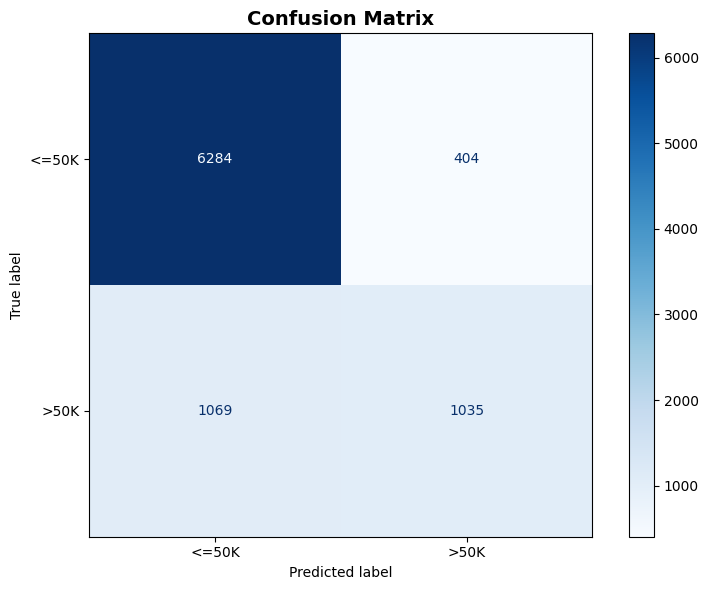


True Negatives:   6284
False Positives:   404
False Negatives:  1069
True Positives:   1035


In [139]:
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives:  {cm[0][0]:5d}")
print(f"False Positives: {cm[0][1]:5d}")
print(f"False Negatives: {cm[1][0]:5d}")
print(f"True Positives:  {cm[1][1]:5d}")

## 5. Classification Report

In [140]:
print(classification_report(y_val, y_pred, target_names=['<=50K', '>50K']))

              precision    recall  f1-score   support

       <=50K       0.85      0.94      0.90      6688
        >50K       0.72      0.49      0.58      2104

    accuracy                           0.83      8792
   macro avg       0.79      0.72      0.74      8792
weighted avg       0.82      0.83      0.82      8792



## 6. Metrics Visualization

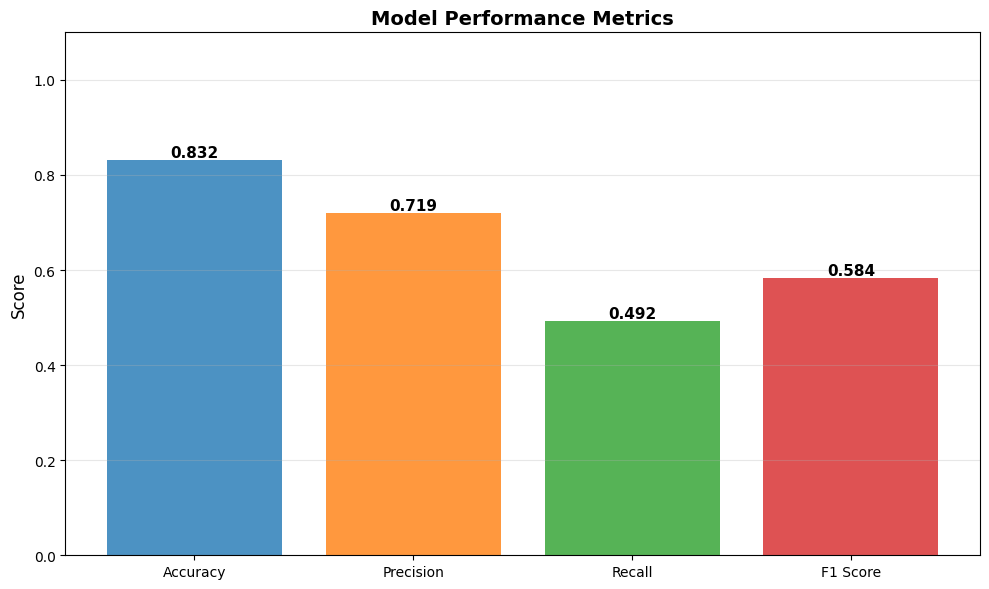

In [141]:
# Bar plot of metrics
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = list(metrics.keys())
metric_values = list(metrics.values())

bars = ax.bar(metric_names, metric_values, 
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], 
              alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.3f}',
           ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Feature Importance (Weights Analysis)

In logistic regression, the weights represent feature importance.
- **Positive weights** → increase probability of >50K income
- **Negative weights** → decrease probability of >50K income

In [142]:
# Extract feature weights from our custom model
preprocessor = model.named_steps['preprocess']
logreg = model.named_steps['logreg']

# Get feature names
feature_names = []

# Numeric features
numeric_features = preprocessor.transformers_[0][2]
feature_names.extend(numeric_features)

# Categorical features (one-hot encoded)
cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
cat_feature_names = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])
feature_names.extend(cat_feature_names)

# Get weights (flatten from column vector)
weights = logreg.weights.flatten()

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights,
    'Abs_Weight': np.abs(weights)
})

importance_df = importance_df.sort_values('Abs_Weight', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Features:
                          Feature    Weight  Abs_Weight
                  educational-num  0.660146    0.660146
                     capital-gain  0.655608    0.655608
     marital-status_Never-married -0.584401    0.584401
marital-status_Married-civ-spouse  0.515347    0.515347
       relationship_Not-in-family -0.415996    0.415996
                    gender_Female -0.414156    0.414156
             relationship_Husband  0.339620    0.339620
                   hours-per-week  0.337707    0.337707
                              age  0.333100    0.333100
     native-country_United-States -0.313789    0.313789
           relationship_Own-child -0.303710    0.303710
          marital-status_Divorced -0.264434    0.264434
                education_HS-grad -0.261489    0.261489
           relationship_Unmarried -0.251748    0.251748
                       race_White -0.245178    0.245178
                     capital-loss  0.221997    0.221997
                

## 8. Feature Weight Visualization

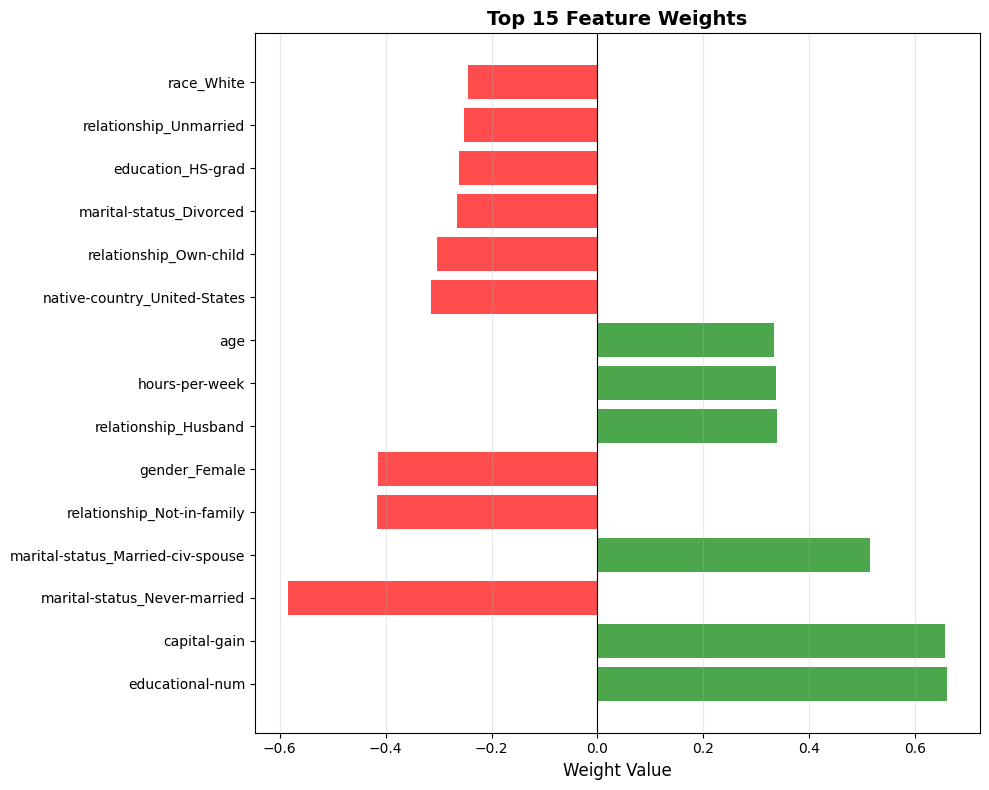

In [143]:
# Plot top 15 features
top_n = 15
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in top_features['Weight']]

ax.barh(range(len(top_features)), top_features['Weight'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Weight Value', fontsize=12)
ax.set_title(f'Top {top_n} Feature Weights', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary

### Model Details
- **Implementation**: Custom Logistic Regression with Gradient Descent
- **Algorithm**: Binary Cross-Entropy Loss + Gradient Updates
- **Training Set**: 80% of data
- **Validation Set**: 20% of data

### Key Mathematical Components
1. **Sigmoid Function**: σ(z) = 1/(1 + e^(-z))
2. **Loss Function**: Binary Cross-Entropy
3. **Optimization**: Gradient Descent
4. **Decision Boundary**: Probability threshold = 0.5

### Interpretation
- **Green bars** (positive weights) → Features that increase P(income > 50K)
- **Red bars** (negative weights) → Features that decrease P(income > 50K)